# Importation

In [1]:
import re
import os
import kagglehub
import keras
import keras_hub
import keras_tuner
import pandas as pd
import numpy as np
import pkuseg
import tensorflow as tf
from datasets import Dataset
from pypinyin import lazy_pinyin
from keras.layers import (
    LSTM,
    Dense,
    Embedding,
    Input,
    StringLookup,
    TextVectorization,
)
from keras.models import Model
import pickle as pk
import gc

path = kagglehub.dataset_download("noxmoon/chinese-official-daily-news-since-2016")

print("Path to dataset files:", path)

print(tf.config.list_physical_devices("GPU"))

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

Path to dataset files: /Users/perrineqhn/.cache/kagglehub/datasets/noxmoon/chinese-official-daily-news-since-2016/versions/1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Création du corpus

In [2]:
dataset = pd.read_csv(path+"/chinese_news.csv")
# Print dataset information
print("Dataset information:")
print(dataset.info())
# Print dataset head
print("Dataset head:")
print(dataset.head())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20738 entries, 0 to 20737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      20738 non-null  object
 1   tag       20738 non-null  object
 2   headline  20738 non-null  object
 3   content   20631 non-null  object
dtypes: object(4)
memory usage: 648.2+ KB
None
Dataset head:
         date   tag                                           headline  \
0  2016-01-01  详细全文  陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...   
1  2016-01-01  详细全文                             中央军委印发《关于深化国防和军队改革的意见》   
2  2016-01-01  详细全文                           《习近平关于严明党的纪律和规矩论述摘编》出版发行   
3  2016-01-01  详细全文                                 以实际行动向党中央看齐 向高标准努力   
4  2016-01-01  详细全文                                 【年终特稿】关键之年 改革挺进深水区   

                                             content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...  
1  经中央军委主席习近平批准，中央军委近日印发了《关

In [3]:
# Prétraitement de content (suppression des caractères non chinois, normalisation des espaces)
def clean_content(text):
    if not isinstance(text, str):
        return ""
    
    # Garder les caractères chinois et ponctuation chinoise
    text = re.sub(r"[^\u4e00-\u9fff\u3000-\u303F\uff00-\uffef]", "", text)
    
    # Normaliser les espaces (rare, mais au cas où)
    text = text.replace(" ", "").strip()

    return text

# Remplacer les valeurs manquantes par une chaîne vide
dataset["content"] = dataset["content"].fillna("")

# Appliquer le prétraitement à la colonne 'content'
dataset['cleaned_content'] = dataset['content'].apply(clean_content)

# Filtrer les lignes où 'cleaned_content' est vide
dataset = dataset[dataset["cleaned_content"].str.strip() != ""].reset_index(drop=True)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after preprocessing:")
print(dataset[['content', 'cleaned_content']].head())

seg = pkuseg.pkuseg()
dataset["tokens"] = dataset["cleaned_content"].apply(lambda x: seg.cut(x))

# Aperçu
print(dataset["tokens"].head())

Dataset after preprocessing:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                                     cleaned_content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会年月日在...  
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。《意见》强调，...  
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...  
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...  
4  刚刚过去的年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，集中发力...  
0    [中国, 人民, 解放军, 陆军, 领导, 机构, 、, 中国, 人民, 解放军, 火箭军,...
1    [经, 中央军委, 主席, 习近平, 批准, ，, 中央军委, 近日, 印发, 了, 《, ...
2    [由, 中共中央, 纪律, 检查, 委员会, 、, 中共中央, 文献, 研究室, 编辑, 的...
3    [广大, 党员, 干部, 正在, 积极, 学习, 习近平, 总书记, 在, 中央, 政治局,...
4    [刚刚, 过去, 的, 年, ，, 是, 全面, 深化, 改革, 的, 关键, 之, 年, ...
Name: tokens, dtype: object


In [4]:
# convert the content column to pinyin
t9_map = {
    "a": "2", "b": "2", "c": "2",
    "d": "3", "e": "3", "f": "3",
    "g": "4", "h": "4", "i": "4",
    "j": "5", "k": "5", "l": "5",
    "m": "6", "n": "6", "o": "6",
    "p": "7", "q": "7", "r": "7", "s": "7",
    "t": "8", "u": "8", "v": "8",
    "w": "9", "x": "9", "y": "9", "z": "9",
    "1": "1", "2": "2", "3": "3", "4": "4",
    "5": "5", "6": "6", "7": "7", "8": "8",
    "9": "9", "0": "0",
    "。":"。", "，":"，", "？":"？", "！":"！",
}

# Fonction pour convertir une chaîne de caractères en code T9
def pinyin_to_t9(text):
    t9_code = ""
    if pd.isna(text):
        return ""
    for char in text.lower():
        t9_code += t9_map.get(char, char)  # Conserver les caractères non mappés
    return t9_code

def validate_t9(t9_code):
    # Vérifie que le code T9 est numérique (ou vide pour ponctuation)
    return bool(re.match(r'^[0-9]+$', t9_code)) or t9_code in {"。", "，", "？", "！"}

def generer_sequence_contextuelle(row):
    tokens = row["tokens"]
    sequence = []
    for token in tokens:
        if not isinstance(token, str) or not re.search(r'[\u4e00-\u9fff]', token):
            continue
        for char, py in zip(token, lazy_pinyin(token)):
            t9 = pinyin_to_t9(py)
            if validate_t9(t9):  # Vérifier que le T9 est valide
                sequence.append(f"{char}|{py}|{t9}")
    return ' '.join(sequence)

dataset["char_pinyin_t9_sequence"] = dataset.apply(generer_sequence_contextuelle, axis=1)

# Filtrer les lignes où 'char_pinyin_t9_sequence' est vide
dataset = dataset[dataset["char_pinyin_t9_sequence"].str.strip() != ""].reset_index(drop=True)

# Sauvegarder le fichier
dataset[["char_pinyin_t9_sequence"]].to_csv("sequences_char_pinyin_t9.csv", index=False)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after generating sequences:")
print(dataset[['content', 'char_pinyin_t9_sequence']].head())

Dataset after generating sequences:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                             char_pinyin_t9_sequence  
0  中|zhong|94664 国|guo|486 人|ren|736 民|min|646 解|...  
1  经|jing|5464 中|zhong|94664 央|yang|9264 军|jun|58...  
2  由|you|968 中|zhong|94664 共|gong|4664 中|zhong|94...  
3  广|guang|48264 大|da|32 党|dang|3264 员|yuan|9826 ...  
4  刚|gang|4264 刚|gang|4264 过|guo|486 去|qu|78 的|de...  


# Création du dataset pour le modèle

In [5]:
# Transformer en séquences complètes
input_t9_sequences = []
target_char_sequences = []
MAX_SEQUENCE_LENGTH = 100

for seq in dataset["char_pinyin_t9_sequence"]:
    triplets = seq.strip().split(" ")
    t9_seq = []
    char_seq = []
    
    # Extraire les paires char|T9 pour chaque phrase
    for triplet in triplets[:MAX_SEQUENCE_LENGTH]:  # Tronquer à MAX_SEQUENCE_LENGTH
        parts = triplet.split("|")
        if len(parts) == 3:
            char, _, t9 = parts
            if validate_t9(t9):  # Vérifier que le T9 est valide
                char_seq.append(char)
                t9_seq.append(t9)
    
    # Ajouter les séquences T9 et caractères si non vides
    if t9_seq and char_seq:
        input_t9_sequences.append(" ".join(t9_seq))
        target_char_sequences.append("".join(char_seq)) # A voir si on garde les espaces ou pas

# Créer un DataFrame
df_sequences = pd.DataFrame({
    "input_t9_sequence": input_t9_sequences,
    "target_char_sequence": target_char_sequences
})

# Filtrer les séquences vides (par précaution)
df_sequences = df_sequences[df_sequences["input_t9_sequence"].str.strip() != ""]
df_sequences = df_sequences[df_sequences["target_char_sequence"].str.strip() != ""]

In [6]:
print("DataFrame sequences:")
print(df_sequences.head())

DataFrame sequences:
                                   input_t9_sequence  \
0  94664 486 736 646 543 3264 586 58 586 5464 326...   
1  5464 94664 9264 586 934 948 94 94 546 7464 74 ...   
2  968 94664 4664 94664 9264 54 58 5426 242 934 9...   
3  48264 32 3264 9826 426 28 94364 924 54 54 983 ...   
4  4264 4264 486 78 33 6426 744 7826 6426 7436 48...   

                                target_char_sequence  
0  中国人民解放军陆军领导机构中国人民解放军火箭军中国人民解放军战略支援部队成立大会年月日在八一...  
1  经中央军委主席习近平批准中央军委近日印发了关于深化国防和军队改革的意见意见强调党的十八大以来...  
2  由中共中央纪律检查委员会中共中央文献研究室编辑的习近平关于严明党的纪律和规矩论述摘编一书近日...  
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话大家纷纷表示要把践...  
4  刚刚过去的年是全面深化改革的关键之年改革集中发力在制约经济社会发展的深层次矛盾集中发力在妨碍...  


In [7]:
# Utiliser tf.data.Dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((df_sequences['input_t9_sequence'], df_sequences['target_char_sequence'])).prefetch(tf.data.AUTOTUNE)
tf_dataset.take(1).get_single_element()

I0000 00:00:1744796572.769715 1895937 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744796572.769735 1895937 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(<tf.Tensor: shape=(), dtype=string, numpy=b'94664 486 736 646 543 3264 586 58 586 5464 326 54 468 94664 486 736 646 543 3264 586 486 5426 586 94664 486 736 646 543 3264 586 9426 583 944 9826 28 384 24364 54 32 484 6426 983 74 924 22 94 32 568 5664 94664 58 9464 94664 4664 94664 9264 9664 748 54 486 542 948 94 94664 9264 586 934 948 94 94 546 7464 94264 58 586 486 5426 586 9426 583 944 9826 28 384 7468 98 586 74 2464 944 986 24 324 2426 3264 94664 9264 43 94664 9264'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b\xe9\xa2\x86\xe5\xaf\xbc\xe6\x9c\xba\xe6\x9e\x84\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe7\x81\xab\xe7\xae\xad\xe5\x86\x9b\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe6\x88\x98\xe7\x95\xa5\xe6\x94\xaf\xe6\x8f\xb4\xe9\x83\xa8\xe9\x98\x9f\xe6\x88\x90\xe7\xab\x8b\xe5\xa4\xa7\xe4\xbc\x9a\

## Encoder les données pour Keras

In [8]:
# TextVectorization
input_tv = keras.layers.TextVectorization(output_mode='int',
                                          split='character',
                                          standardize=None,
                                          ragged=True,)

target_tv = keras.layers.TextVectorization(output_mode='int',
                                           split='character',
                                           standardize=None,
                                           ragged=True,)

tmp_t9_ds = tf_dataset.map(lambda t9, target: tf.strings.reduce_join(tf.strings.split(t9, " "), separator=""))
t9_ds = tf_dataset.map(lambda t9, target: t9)
target_ds = tf_dataset.map(lambda t9, target: target)
input_tv.adapt(tmp_t9_ds)
target_tv.adapt(target_ds)

In [9]:
# Le vocabulaire pour t9 input
print(input_tv.get_vocabulary())
print(target_tv.get_vocabulary())

['', '[UNK]', np.str_('4'), np.str_('6'), np.str_('2'), np.str_('3'), np.str_('8'), np.str_('9'), np.str_('5'), np.str_('7'), np.str_('。')]
['', '[UNK]', np.str_('的'), np.str_('国'), np.str_('中'), np.str_('在'), np.str_('会'), np.str_('人'), np.str_('大'), np.str_('一'), np.str_('日'), np.str_('发'), np.str_('年'), np.str_('和'), np.str_('全'), np.str_('天'), np.str_('行'), np.str_('了'), np.str_('主'), np.str_('地'), np.str_('出'), np.str_('部'), np.str_('新'), np.str_('总'), np.str_('家'), np.str_('近'), np.str_('民'), np.str_('政'), np.str_('今'), np.str_('是'), np.str_('为'), np.str_('平'), np.str_('作'), np.str_('上'), np.str_('开'), np.str_('进'), np.str_('表'), np.str_('展'), np.str_('成'), np.str_('来'), np.str_('方'), np.str_('习'), np.str_('共'), np.str_('央'), np.str_('对'), np.str_('有'), np.str_('时'), np.str_('委'), np.str_('动'), np.str_('以'), np.str_('合'), np.str_('个'), np.str_('议'), np.str_('月'), np.str_('员'), np.str_('多'), np.str_('长'), np.str_('生'), np.str_('务'), np.str_('将'), np.str_('席'), np.str_('区'), np.str

In [10]:
@tf.function
def split_and_vectorize(t9_seq, char_seq, context_size=5):
    
    # Split chaque séquence T9 (par espace)
    t9_parts = tf.strings.split(t9_seq, " ")  # tf.TensorShape([None])

    # Split la séquence de caractères (par caractère UTF-8)
    char_parts = tf.strings.unicode_split(char_seq, "UTF-8")

    # Padder la séquence de caractères pour avoir le contexte pour tous les caractères
    char_seq_padded = tf.strings.join([tf.constant("     "), char_seq])
    char_parts_padded = tf.strings.unicode_split(char_seq_padded, "UTF-8")

    # Vérification de la même longueur entre la séquence de t9 et celle de caractères
    assert_op = tf.debugging.assert_equal(tf.shape(t9_parts)[0], tf.shape(char_parts)[0])

    with tf.control_dependencies([assert_op]):
        
        # Vectorisation : chaque chiffre dans chaque t9_part est un caractère
        vectorized_t9 = input_tv(t9_parts)       # RaggedTensor: [nb_sous_seq, longueur_t9]
        vectorized_target = target_tv(char_parts)  # RaggedTensor: [nb_sous_seq, 1]

        # Convertit RaggedTensor en Tensor avec padding (0 par défaut, qui sera ignoré lors du Embedding Layer, mask_zero=True)
        t9_tensor = vectorized_t9.to_tensor(default_value=0)
        target_tensor = vectorized_target.to_tensor(default_value=0)
        target_tensor = tf.squeeze(target_tensor, axis=-1)
        
        # Contexte
        # Vectorisation du target padded
        vectorized_target_padded = target_tv(char_parts_padded).to_tensor(default_value=0)
        # Avoir la longueur de caractères après le padding
        padded_seq_len = tf.shape(vectorized_target_padded)[0]
        # Initialiser un tenseur pour le contexte
        contexts = tf.TensorArray(dtype=tf.int64, size=padded_seq_len - context_size)
        # Parcourir chaque caractère sauf le dernier
        for i in tf.range(padded_seq_len - context_size):
            # Récupérer dynamiquement un contexte de taille fixe
            context = vectorized_target_padded[i:i+context_size]
            # Écrire dans la position correspondante du tenseur array
            contexts = contexts.write(i, context)
        # Piler le tenseur
        contexts_tensor = contexts.stack()
        contexts_tensor = tf.squeeze(contexts_tensor, axis=-1)

        return {"t9_input": t9_tensor, "context_input": contexts_tensor}, target_tensor

transformed_dataset = tf_dataset.map(
    lambda t9, target: split_and_vectorize(t9, target),
    num_parallel_calls=20
)

In [11]:
transformed_dataset.padded_batch(256).take(1).get_single_element()

({'t9_input': <tf.Tensor: shape=(256, 100, 6), dtype=int64, numpy=
  array([[[7, 2, 3, 3, 2, 0],
          [2, 6, 3, 0, 0, 0],
          [9, 5, 3, 0, 0, 0],
          ...,
          [2, 5, 0, 0, 0, 0],
          [7, 2, 3, 3, 2, 0],
          [7, 4, 3, 2, 0, 0]],
  
         [[8, 2, 3, 2, 0, 0],
          [7, 2, 3, 3, 2, 0],
          [7, 4, 3, 2, 0, 0],
          ...,
          [2, 5, 0, 0, 0, 0],
          [2, 6, 3, 0, 0, 0],
          [5, 4, 3, 2, 0, 0]],
  
         [[7, 3, 6, 0, 0, 0],
          [7, 2, 3, 3, 2, 0],
          [2, 3, 3, 2, 0, 0],
          ...,
          [7, 2, 3, 3, 2, 0],
          [9, 2, 2, 0, 0, 0],
          [9, 6, 4, 3, 0, 0]],
  
         ...,
  
         [[7, 2, 5, 3, 2, 0],
          [7, 4, 2, 0, 0, 0],
          [7, 2, 2, 0, 0, 0],
          ...,
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]],
  
         [[7, 5, 2, 0, 0, 0],
          [9, 2, 0, 0, 0, 0],
          [6, 2, 4, 3, 0, 0],
          ...,
          [0, 0

## Split train-valid-test

In [12]:
c = transformed_dataset.reduce(0, lambda x,_:x+1).numpy()

shuffled_ds = transformed_dataset.shuffle(buffer_size=c, seed=42)

train_size = c * 80 // 100
test_size = c * 10 // 100
val_size = c - train_size - test_size

ds_train = shuffled_ds.take(train_size).prefetch(tf.data.AUTOTUNE)
ds_val = shuffled_ds.skip(train_size).take(val_size).prefetch(tf.data.AUTOTUNE)
ds_test = shuffled_ds.skip(train_size+val_size).take(test_size).prefetch(tf.data.AUTOTUNE)

print("Taille du train :", ds_train.cardinality().numpy())
print("Taille du validation :", ds_val.cardinality().numpy())
print("Taille du test :", ds_test.cardinality().numpy())

Taille du train : 16503
Taille du validation : 2064
Taille du test : 2062


In [13]:
context_size = 5

ds_train_padded = ds_train.padded_batch(
    128,
    padded_shapes=(
        {
            "t9_input": [MAX_SEQUENCE_LENGTH, 6],
            "context_input": [MAX_SEQUENCE_LENGTH, context_size]
        },
        [MAX_SEQUENCE_LENGTH]  # Pour les étiquettes
    ),
    padding_values=(
        {
            "t9_input": tf.constant(0, dtype=tf.int64),
            "context_input": tf.constant(0, dtype=tf.int64)
        },
        tf.constant(0, dtype=tf.int64)  # Pour les étiquettes
    ),
    drop_remainder=True,
).map(lambda x, y: (x, y, y>0)).prefetch(tf.data.AUTOTUNE)

ds_val_padded = ds_val.padded_batch(
    128,
    padded_shapes=(
        {
            "t9_input": [MAX_SEQUENCE_LENGTH, 6],
            "context_input": [MAX_SEQUENCE_LENGTH, context_size]
        },
        [MAX_SEQUENCE_LENGTH]  # Pour les étiquettes
    ),
    padding_values=(
        {
            "t9_input": tf.constant(0, dtype=tf.int64),
            "context_input": tf.constant(0, dtype=tf.int64)
        },
        tf.constant(0, dtype=tf.int64)  # Pour les étiquettes
    ),
    drop_remainder=True,
).map(lambda x, y: (x, y, y>0)).prefetch(tf.data.AUTOTUNE)

ds_test_padded = ds_test.padded_batch(
    128,
    padded_shapes=(
        {
            "t9_input": [MAX_SEQUENCE_LENGTH, 6],
            "context_input": [MAX_SEQUENCE_LENGTH, context_size]
        },
        [MAX_SEQUENCE_LENGTH]  # Pour les étiquettes
    ),
    padding_values=(
        {
            "t9_input": tf.constant(0, dtype=tf.int64),
            "context_input": tf.constant(0, dtype=tf.int64)
        },
        tf.constant(0, dtype=tf.int64)  # Pour les étiquettes
    ),
    drop_remainder=True,
).map(lambda x, y: (x, y, y>0)).prefetch(tf.data.AUTOTUNE)

In [14]:
ds_train_padded.take(1).get_single_element()

({'t9_input': <tf.Tensor: shape=(128, 100, 6), dtype=int64, numpy=
  array([[[8, 2, 3, 0, 0, 0],
          [6, 2, 4, 3, 0, 0],
          [9, 2, 4, 3, 2, 0],
          ...,
          [5, 4, 0, 0, 0, 0],
          [9, 2, 0, 0, 0, 0],
          [9, 2, 2, 0, 0, 0]],
  
         [[7, 2, 0, 0, 0, 0],
          [8, 2, 3, 0, 0, 0],
          [9, 2, 3, 2, 0, 0],
          ...,
          [7, 2, 4, 3, 0, 0],
          [9, 2, 4, 3, 2, 0],
          [2, 4, 2, 0, 0, 0]],
  
         [[2, 6, 3, 0, 0, 0],
          [8, 2, 4, 0, 0, 0],
          [7, 2, 6, 0, 0, 0],
          ...,
          [7, 2, 0, 0, 0, 0],
          [8, 2, 3, 0, 0, 0],
          [9, 2, 3, 2, 0, 0]],
  
         ...,
  
         [[3, 2, 3, 2, 0, 0],
          [6, 2, 4, 3, 0, 0],
          [8, 2, 6, 0, 0, 0],
          ...,
          [5, 5, 3, 2, 0, 0],
          [2, 6, 3, 0, 0, 0],
          [5, 3, 3, 2, 0, 0]],
  
         [[2, 6, 3, 0, 0, 0],
          [8, 2, 4, 0, 0, 0],
          [7, 2, 6, 0, 0, 0],
          ...,
          [9, 6

In [15]:
if not tf.io.gfile.exists("data"):
    tf.io.gfile.makedirs("data")

# Sauvegarder les jeux de données
tf.data.Dataset.save(ds_train_padded, "data/train_dataset")
tf.data.Dataset.save(ds_val_padded, "data/val_dataset")
tf.data.Dataset.save(ds_test_padded, "data/test_dataset")

# Sauvegarder les vectorisateurs
with open("data/input_vectorizer.pkl", "wb") as f:
    pk.dump(input_tv, f)

with open("data/target_vectorizer.pkl", "wb") as f:
    pk.dump(target_tv, f)

# Sauvegarder les paramètres
params = {
    "MAX_SEQUENCE_LENGTH": MAX_SEQUENCE_LENGTH,
    "context_size": context_size,
    "input_vocab_size": len(input_tv.get_vocabulary()),
    "target_vocab_size": len(target_tv.get_vocabulary()),
}

with open("data/params.pkl", "wb") as f:
    pk.dump(params, f)


In [16]:
ds_train_padded.take(1).get_single_element()

({'t9_input': <tf.Tensor: shape=(128, 100, 6), dtype=int64, numpy=
  array([[[7, 2, 6, 0, 0, 0],
          [8, 2, 4, 3, 0, 0],
          [4, 6, 0, 0, 0, 0],
          ...,
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]],
  
         [[2, 6, 3, 0, 0, 0],
          [7, 6, 0, 0, 0, 0],
          [7, 6, 4, 3, 0, 0],
          ...,
          [9, 2, 5, 0, 0, 0],
          [2, 6, 2, 0, 0, 0],
          [2, 3, 3, 2, 0, 0]],
  
         [[9, 6, 2, 0, 0, 0],
          [2, 3, 6, 0, 0, 0],
          [7, 2, 0, 0, 0, 0],
          ...,
          [7, 2, 6, 0, 0, 0],
          [4, 2, 4, 0, 0, 0],
          [7, 2, 0, 0, 0, 0]],
  
         ...,
  
         [[2, 5, 3, 0, 0, 0],
          [8, 6, 0, 0, 0, 0],
          [7, 2, 0, 0, 0, 0],
          ...,
          [7, 4, 3, 0, 0, 0],
          [9, 2, 3, 6, 0, 0],
          [5, 6, 4, 3, 0, 0]],
  
         [[5, 4, 2, 0, 0, 0],
          [2, 4, 3, 0, 0, 0],
          [8, 5, 0, 0, 0, 0],
          ...,
          [0, 0

# Modèle

Sogou T9 est une méthode d’entrée intelligente qui :

- Prend des séquences numériques (ex. : "94664 486" pour "zhong guo").
- Génère des séquences de caractères chinois (ex. : "中国").
- Utilise le contexte (mots précédents) pour désambiguïser les prédictions.
- Est optimisé pour la vitesse et la précision, souvent avec des modèles entraînés sur de vastes corpus.

Pour reproduire cela, il faut utiliser un modèle seq2seq avec un encodeur-décodeur (2 entrées) :

- Encodeur : Lit la séquence T9 et la compresse en une représentation contextuelle.
- Décodeur : Génère la séquence de caractères chinois à partir de cette représentation.

[Functional API](https://keras.io/guides/functional_api/)
[Introduction Seq2Seq](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

In [2]:
# Chargement des données
def load_dataset(path):
    return tf.data.Dataset.load(path)

def load_vectorizer(path):
    with open(path, "rb") as f:
        return pk.load(f)
    
def load_params(path):
    with open(path, "rb") as f:
        return pk.load(f)
    
# Chargement des jeux de données
ds_train_padded = load_dataset("data/train_dataset")
ds_val_padded = load_dataset("data/val_dataset")
ds_test_padded = load_dataset("data/test_dataset")

# Chargement des vectorisateurs
input_tv = load_vectorizer("data/input_vectorizer.pkl")
target_tv = load_vectorizer("data/target_vectorizer.pkl")

# Chargement des paramètres
params = load_params("data/params.pkl")
context_size = params["context_size"]
MAX_SEQUENCE_LENGTH = params["MAX_SEQUENCE_LENGTH"]
input_vocab_size = params["input_vocab_size"]
target_vocab_size = params["target_vocab_size"]


I0000 00:00:1744797191.254146 1929735 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744797191.254198 1929735 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
ds_train_padded.take(1).get_single_element()

({'t9_input': <tf.Tensor: shape=(128, 100, 6), dtype=int64, numpy=
  array([[[8, 2, 3, 0, 0, 0],
          [9, 2, 0, 0, 0, 0],
          [7, 3, 6, 0, 0, 0],
          ...,
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]],
  
         [[7, 5, 0, 0, 0, 0],
          [3, 5, 3, 0, 0, 0],
          [2, 6, 0, 0, 0, 0],
          ...,
          [5, 6, 3, 0, 0, 0],
          [8, 4, 2, 0, 0, 0],
          [2, 6, 0, 0, 0, 0]],
  
         [[9, 2, 2, 0, 0, 0],
          [8, 2, 5, 0, 0, 0],
          [3, 4, 3, 0, 0, 0],
          ...,
          [7, 2, 3, 3, 2, 0],
          [2, 6, 3, 0, 0, 0],
          [5, 5, 0, 0, 0, 0]],
  
         ...,
  
         [[4, 2, 3, 2, 0, 0],
          [9, 2, 5, 3, 0, 0],
          [3, 2, 4, 3, 0, 0],
          ...,
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]],
  
         [[7, 2, 3, 2, 0, 0],
          [2, 6, 3, 0, 0, 0],
          [6, 6, 3, 0, 0, 0],
          ...,
          [7, 6

In [4]:
# Custom layer to mask embeddings for token ID 1
class MaskToken1Layer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskToken1Layer, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        embeddings, input_ids = inputs
        # Créer un masque où input_ids != 1
        mask_token_1 = tf.cast(tf.not_equal(input_ids, 1), tf.float32)
        
        # Développer le masque pour faire correspondre la forme des integers
        mask_token_1 = tf.expand_dims(mask_token_1, -1) # [batch_size, seq_len, 1]

        # Appliquer un masque aux intégres
        masked_embeddings = embeddings * mask_token_1

        return masked_embeddings

    def compute_mask(self, inputs, mask=None):
        embeddings, input_ids = inputs
        # Since input_ids is a KerasTensor, we rely on the Embedding's mask_zero
        # and let Keras propagate the mask. We don't need to compute a new mask here
        # because mask_zero=True in the Embedding layer already handles token ID 0,
        # and token ID 1 is handled in call().
        if mask is not None:
            # Use the incoming mask (from mask_zero=True) if available
            return mask
        return None

In [28]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

In [20]:
def build_model(input_tv, output_tv, emb_size, gru_size, context_size=5):
    # Inputs
    t9_input = keras.layers.Input(shape=(None, 6), name="t9_input")  # (batch, seq_len, t9_len)
    context_input = keras.layers.Input(shape=(None, context_size), name="context_input")  # (batch, seq_len, context_len)

    # ===== T9 processing =====
    t9_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_dim=input_tv.vocabulary_size(),
                         output_dim=emb_size,
                         mask_zero=True),
        name="t9_embedding")(t9_input)
    
    t9_emb = keras.layers.Dropout(0.3, name="t9_embedding_dropout")(t9_emb)

    t9_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(gru_size,
                   activation="tanh",
                   recurrent_activation="sigmoid",
                   dropout=0.3,
                   return_sequences=False),
        name="t9_gru")(t9_emb)

    t9_encoded = keras.layers.LayerNormalization(name="t9_encoding_norm")(t9_encoded)

    # ===== Context processing =====
    context_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_dim=output_tv.vocabulary_size(),
                         output_dim=emb_size,
                         mask_zero=True),
        name="context_embedding")(context_input)
    
    context_emb = keras.layers.Dropout(0.3, name="context_embedding_dropout")(context_emb)
    

    context_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(gru_size,
                   activation="tanh",
                   recurrent_activation="sigmoid",
                   dropout=0.3,
                   return_sequences=False),
        name="context_gru")(context_emb)

    context_encoded = keras.layers.LayerNormalization(name="context_encoding_norm")(context_encoded)

    # ===== Merge & Output =====
    merged = keras.layers.Concatenate(axis=-1, name="merged_features")([t9_encoded, context_encoded])

    output = keras.layers.TimeDistributed(
        keras.layers.Dense(output_tv.vocabulary_size(), activation="softmax"),
        name="softmax")(merged)

    model = keras.Model(inputs={"t9_input": t9_input, "context_input": context_input}, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras_hub.metrics.Perplexity(from_logits=False, mask_token_id=0),
            keras.metrics.SparseCategoricalAccuracy()],
        weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    return model

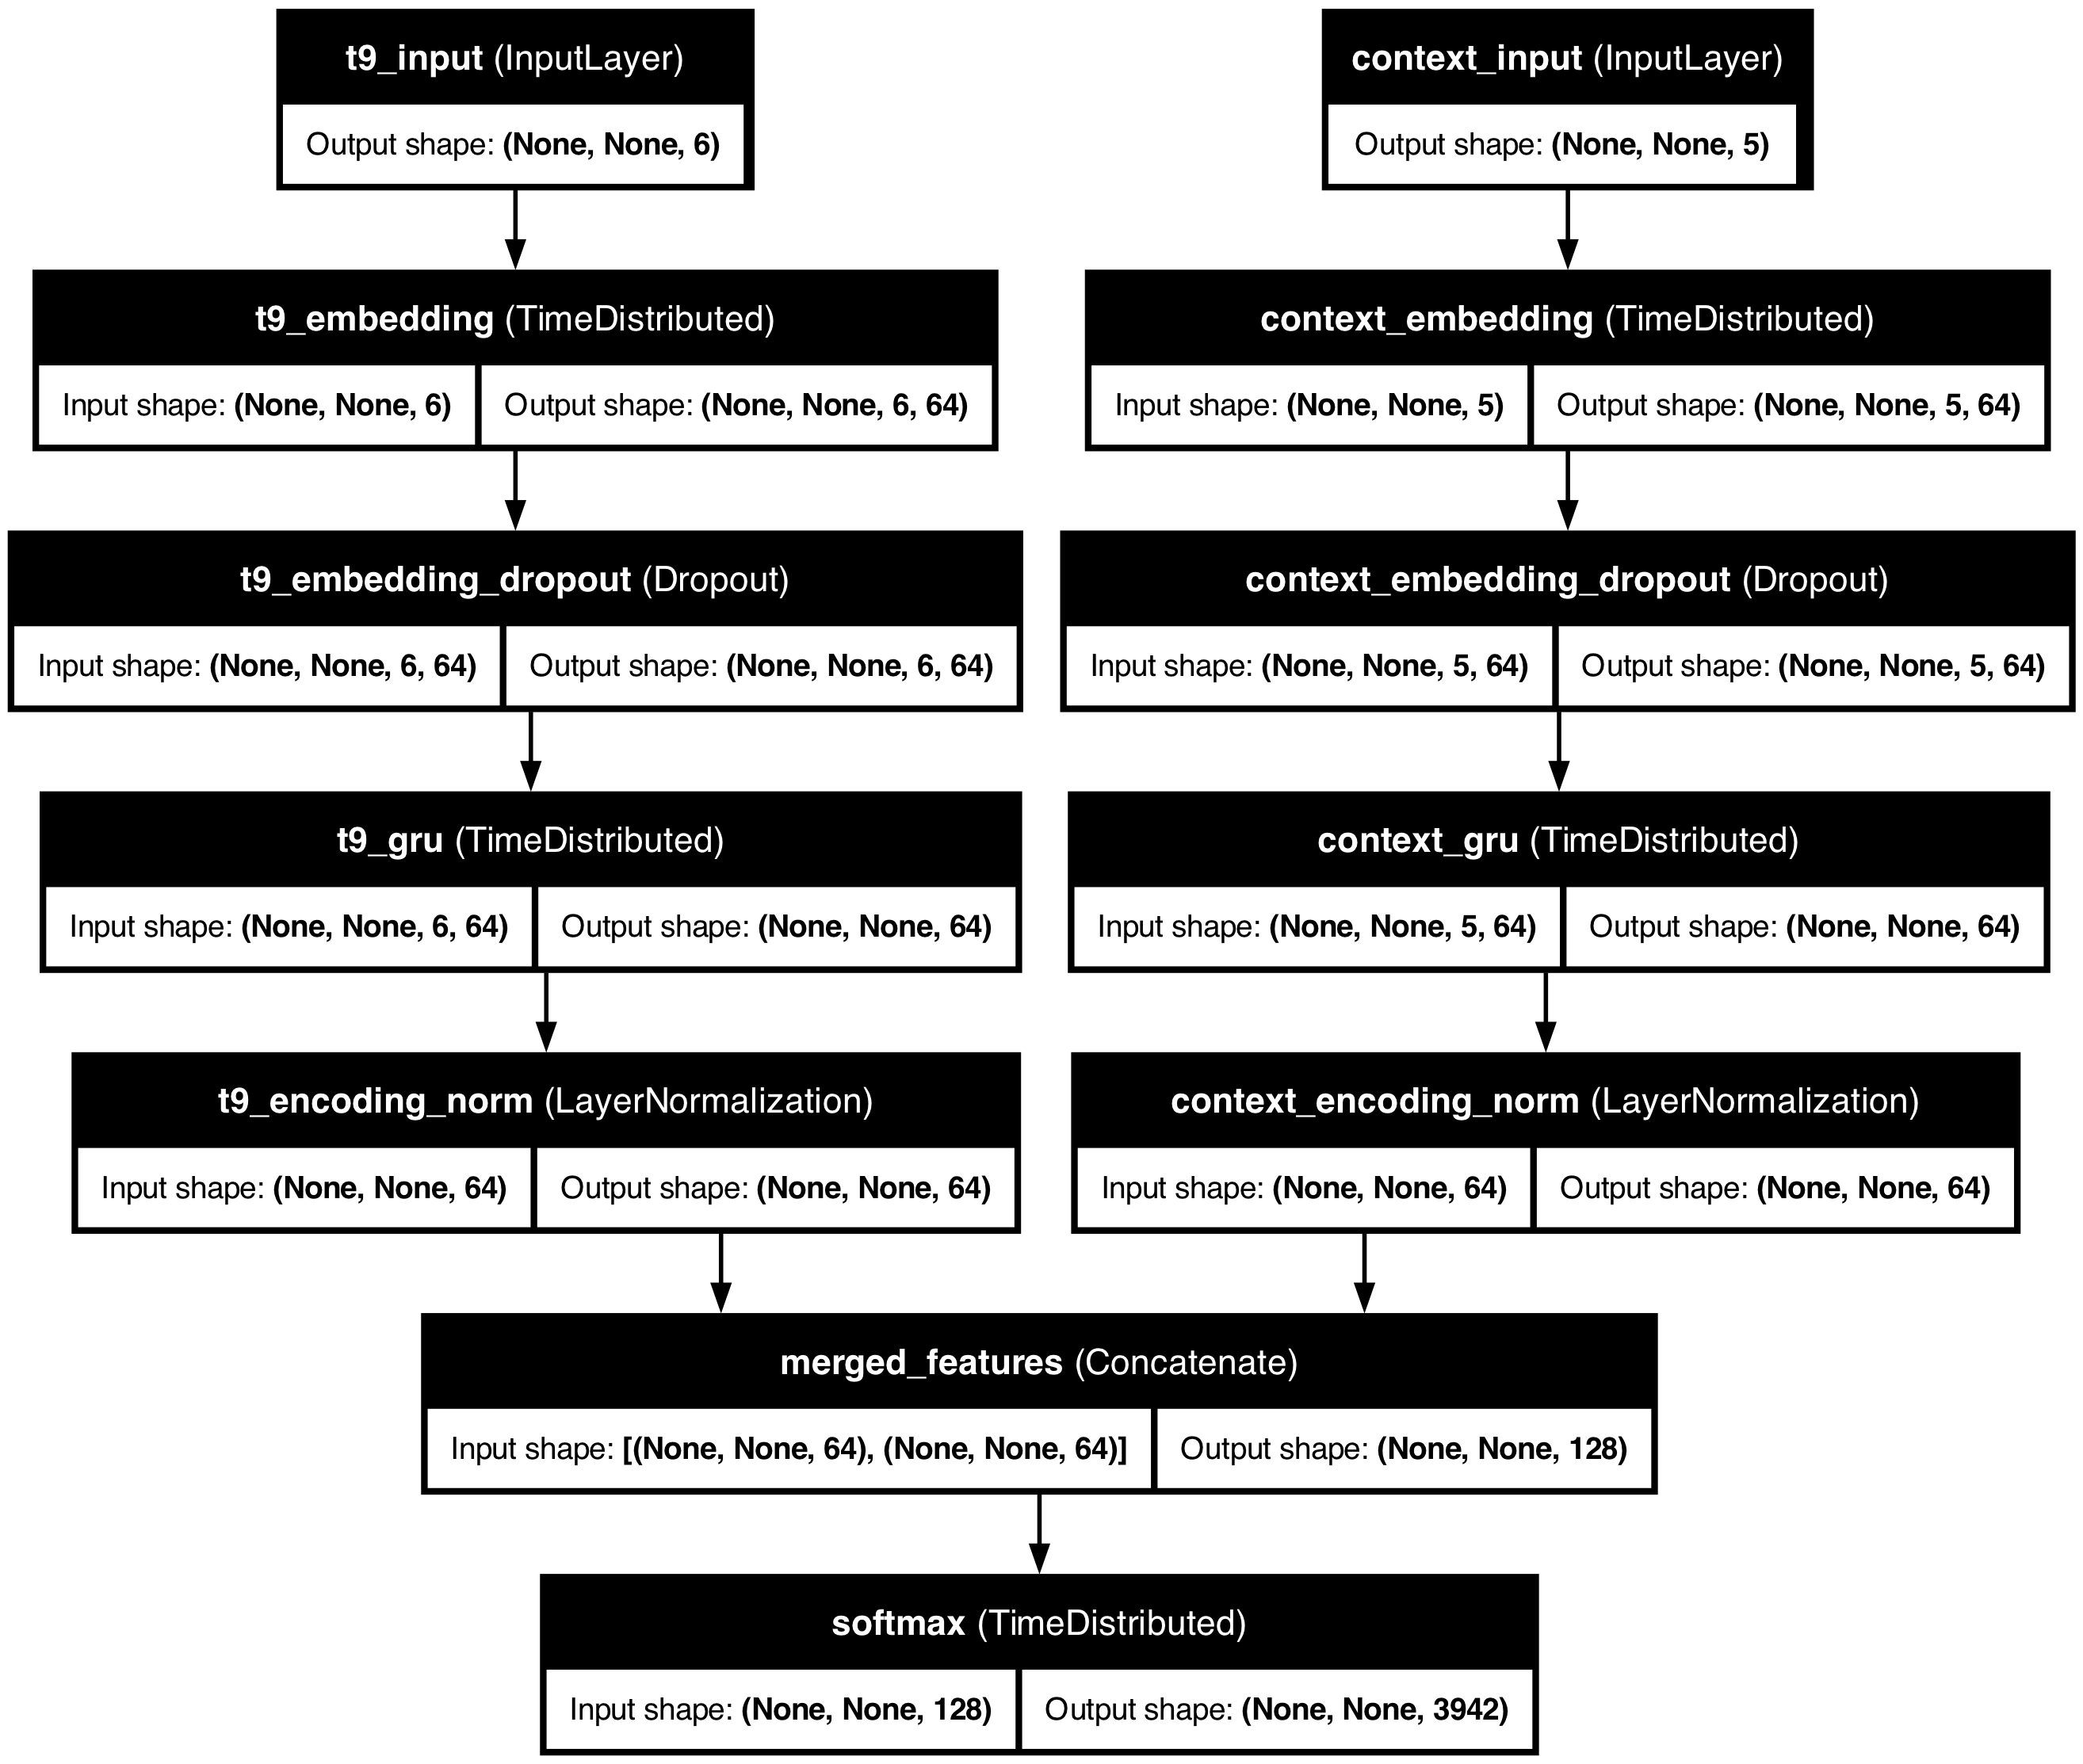

In [21]:
model = build_model(input_tv, target_tv, 64, 64)
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file="model.png")

In [ ]:
model.fit(ds_train_padded.take(20), 
            epochs=30, 
            validation_data=ds_val_padded.take(10), 
            callbacks=[early_stopping]
            )

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - loss: 7.3841 - perplexity: 3331.8625 - sparse_categorical_accuracy: 0.0040 - weighted_sparse_categorical_accuracy: 0.0044 
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 906ms/step - loss: 6.4774 - perplexity: 1231.8137 - sparse_categorical_accuracy: 0.0184 - weighted_sparse_categorical_accuracy: 0.0202
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 799ms/step - loss: 6.0075 - perplexity: 730.0286 - sparse_categorical_accuracy: 0.0185 - weighted_sparse_categorical_accuracy: 0.0203
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 696ms/step - loss: 5.9224 - perplexity: 664.9314 - sparse_categorical_accuracy: 0.0220 - weighted_sparse_categorical_accuracy: 0.0242
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 681ms/step - loss: 5.8028 - perplexity: 583.2482 - sparse_categorical_accuracy: 0.0434 - weighted_sparse_categorical_accuracy: 0.0476
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step - loss: 5.5724 - perplexity: 453.2550 - sparse_categorical_accuracy: 0.0

In [23]:
if not tf.io.gfile.exists("models"):
    tf.io.gfile.makedirs("models")
    
# Sauvegarder le modèle
model.save("models/model_simple.keras")

In [24]:
# Libérer les ressources
tf.keras.backend.clear_session()  # Réinitialise la session TensorFlow
gc.collect()  # Force le garbage collector pour libérer la mémoire

0

In [3]:
def build_model_with_1_mask(input_tv, output_tv, emb_size, gru_size, context_size=5):
    # Inputs
    t9_input = keras.layers.Input(shape=(None, 6), name="t9_input")  # (batch, seq_len, t9_len)
    context_input = keras.layers.Input(shape=(None, context_size), name="context_input")  # (batch, seq_len, context_len)

    # ===== T9 processing =====
    t9_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_dim=input_tv.vocabulary_size(),
                         output_dim=emb_size,
                         mask_zero=True),
        name="t9_embedding")(t9_input)
    
    t9_emb = MaskToken1Layer(name="t9_mask_token_1")([t9_emb, t9_input])

    t9_emb = keras.layers.Dropout(0.3, name="t9_embedding_dropout")(t9_emb)

    t9_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(gru_size,
                   activation="tanh",
                   recurrent_activation="sigmoid",
                   dropout=0.3,
                   return_sequences=False),
        name="t9_gru")(t9_emb)

    t9_encoded = keras.layers.LayerNormalization(name="t9_encoding_norm")(t9_encoded)

    # ===== Context processing =====
    context_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_dim=output_tv.vocabulary_size(),
                         output_dim=emb_size,
                         mask_zero=True),
        name="context_embedding")(context_input)
    
    context_emb = MaskToken1Layer(name="context_mask_token_1")([context_emb, context_input])

    context_emb = keras.layers.Dropout(0.3, name="context_embedding_dropout")(context_emb)
    

    context_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(gru_size,
                   activation="tanh",
                   recurrent_activation="sigmoid",
                   dropout=0.3,
                   return_sequences=False),
        name="context_gru")(context_emb)

    context_encoded = keras.layers.LayerNormalization(name="context_encoding_norm")(context_encoded)

    # ===== Merge & Output =====
    merged = keras.layers.Concatenate(axis=-1, name="merged_features")([t9_encoded, context_encoded])

    output = keras.layers.TimeDistributed(
        keras.layers.Dense(output_tv.vocabulary_size(), activation="softmax"),
        name="softmax")(merged)

    model = keras.Model(inputs={"t9_input": t9_input, "context_input": context_input}, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras_hub.metrics.Perplexity(from_logits=False, mask_token_id=0),
            keras.metrics.SparseCategoricalAccuracy()],
        weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    return model

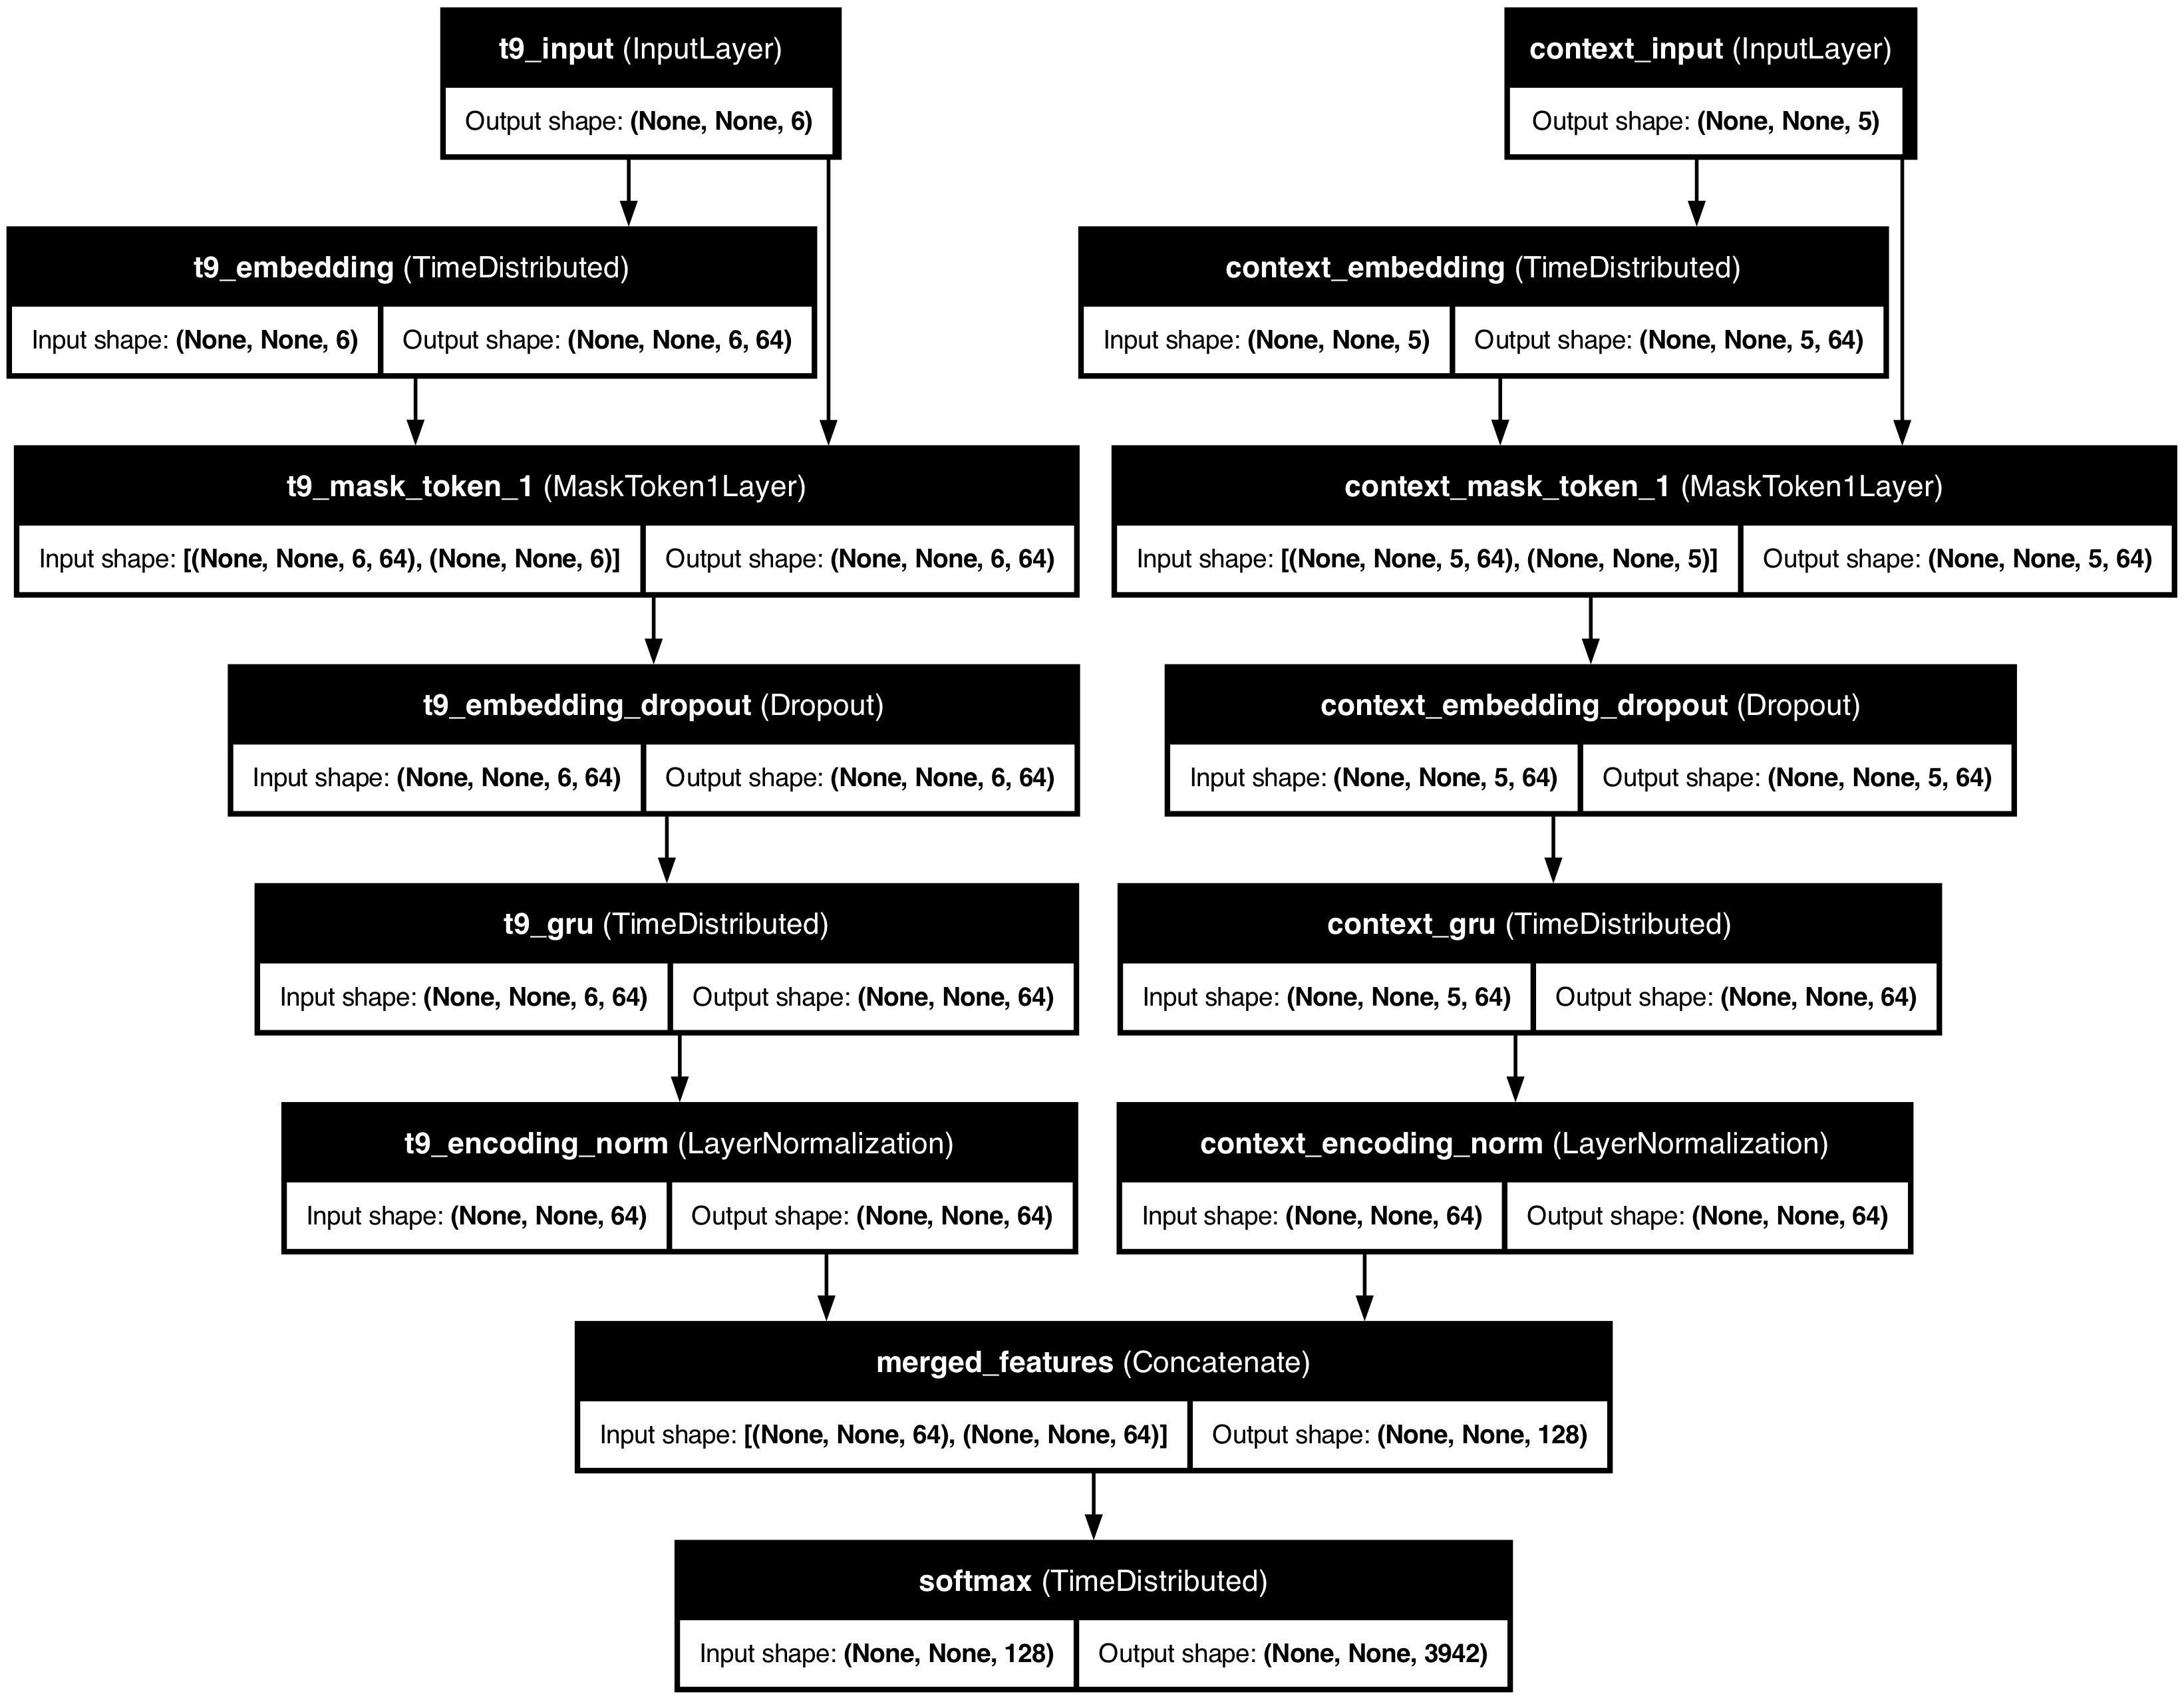

In [39]:
model_with_1_mask = build_model_with_1_mask(input_tv, target_tv, 64, 64)
keras.utils.plot_model(model_with_1_mask, show_shapes=True, show_layer_names=True, to_file="model_with_1_mask.png")

In [ ]:
model_with_1_mask.fit(ds_train_padded.take(20), 
                      epochs=30, 
                      validation_data=ds_val_padded.take(10), 
                      callbacks=[early_stopping]
                      )
model_with_1_mask.save("models/model_with_1_mask.keras")

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 177s 6s/step - loss: 7.2135 - perplexity: 2822.6951 - sparse_categorical_accuracy: 0.0064 - weighted_sparse_categorical_accuracy: 0.0070 - val_loss: 6.1421 - val_perplexity: 785.4546 - val_sparse_categorical_accuracy: 0.0160 - val_weighted_sparse_categorical_accuracy: 0.0174
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 5.9865 - perplexity: 710.8597 - sparse_categorical_accuracy: 0.0257 - weighted_sparse_categorical_accuracy: 0.0281 - val_loss: 5.8275 - val_perplexity: 558.2139 - val_sparse_categorical_accuracy: 0.0525 - val_weighted_sparse_categorical_accuracy: 0.0570
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 5.6225 - perplexity: 478.1497 - sparse_categorical_accuracy: 0.0583 - weighted_sparse_categorical_accuracy: 0.0639 - val_loss: 5.2010 - val_perplexity: 282.7932 - val_sparse_categorical_accuracy: 0.1026 - val_weighted_sparse_categorical_accuracy: 0.1113
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 4.99

[Tutoriel Seq2Seq avec Transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)

In [ ]:
def transformer_block(embed_dim, num_heads, ff_dim, rate=0.1):
    inputs = keras.Input(shape=(None, embed_dim))
    attention = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention = keras.layers.Dropout(rate)(attention)
    out1 = keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ffn = keras.Sequential([
        keras.layers.Dense(ff_dim, activation="relu"),
        keras.layers.Dense(embed_dim),
    ])
    ffn_output = ffn(out1)
    ffn_output = keras.layers.Dropout(rate)(ffn_output)
    outputs = keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return keras.Model(inputs, outputs)

class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = tf.expand_dims(positions, 0)  # [1, seq_len]
        return x + self.pos_emb(positions)  # broadcasting


def build_transformer_model(input_tv, target_tv, embed_dim=64, ff_dim=128, num_heads=4, num_layers=2, context_size=5, max_seq_len=128):
    # Inputs
    t9_input = keras.Input(shape=(None, 6), name="t9_input")  # (batch, seq_len, 6)
    context_input = keras.Input(shape=(None, context_size), name="context_input")  # (batch, seq_len, context_size)

    # ==== T9 Embedding ==== (batch, seq_len, 6) -> (batch, seq_len, 6, embed_dim)
    t9_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(input_tv.vocabulary_size(), embed_dim, mask_zero=True),
        name="t9_embedding"
    )(t9_input)

    t9_emb = MaskToken1Layer(name="t9_mask_token_1")([t9_emb, t9_input])

    # Passage par GRU pour chaque mot T9 (ex : '4663') => représentation vectorielle
    t9_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(embed_dim, return_sequences=False),
        name="t9_gru"
    )(t9_emb)  # (batch, seq_len, embed_dim)

    # Ajout du positional encoding
    t9_encoded = PositionalEmbedding(max_seq_len, embed_dim)(t9_encoded)

    # Plusieurs couches Transformer (T9)
    for i in range(num_layers):
        t9_encoded = transformer_block(embed_dim, num_heads, ff_dim)(t9_encoded)

    # ===== Context processing =====
    context_emb = keras.layers.TimeDistributed(
        keras.layers.Embedding(target_tv.vocabulary_size(), embed_dim, mask_zero=True),
        name="context_embedding"
    )(context_input)

    context_emb = MaskToken1Layer(name="context_mask_token_1")([context_emb, context_input])

    # Encodage GRU de chaque contexte
    context_encoded = keras.layers.TimeDistributed(
        keras.layers.GRU(embed_dim, return_sequences=False),
        name="context_gru"
    )(context_emb)

    context_encoded = PositionalEmbedding(max_seq_len, embed_dim)(context_encoded)

    # Plusieurs couches Transformer (contexte)
    for i in range(num_layers):
        context_encoded = transformer_block(embed_dim, num_heads, ff_dim)(context_encoded)

    # ===== Merge & Output =====
    merged = keras.layers.Concatenate()([t9_encoded, context_encoded])
    x = keras.layers.Dense(ff_dim, activation="relu")(merged)
    x = keras.layers.Dropout(0.2)(x)
    output = keras.layers.Dense(target_tv.vocabulary_size(), activation="softmax")(x)

    model = keras.Model(inputs={"t9_input": t9_input, "context_input": context_input}, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras_hub.metrics.Perplexity(from_logits=False, mask_token_id=0),
            keras.metrics.SparseCategoricalAccuracy()],
        weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    return model

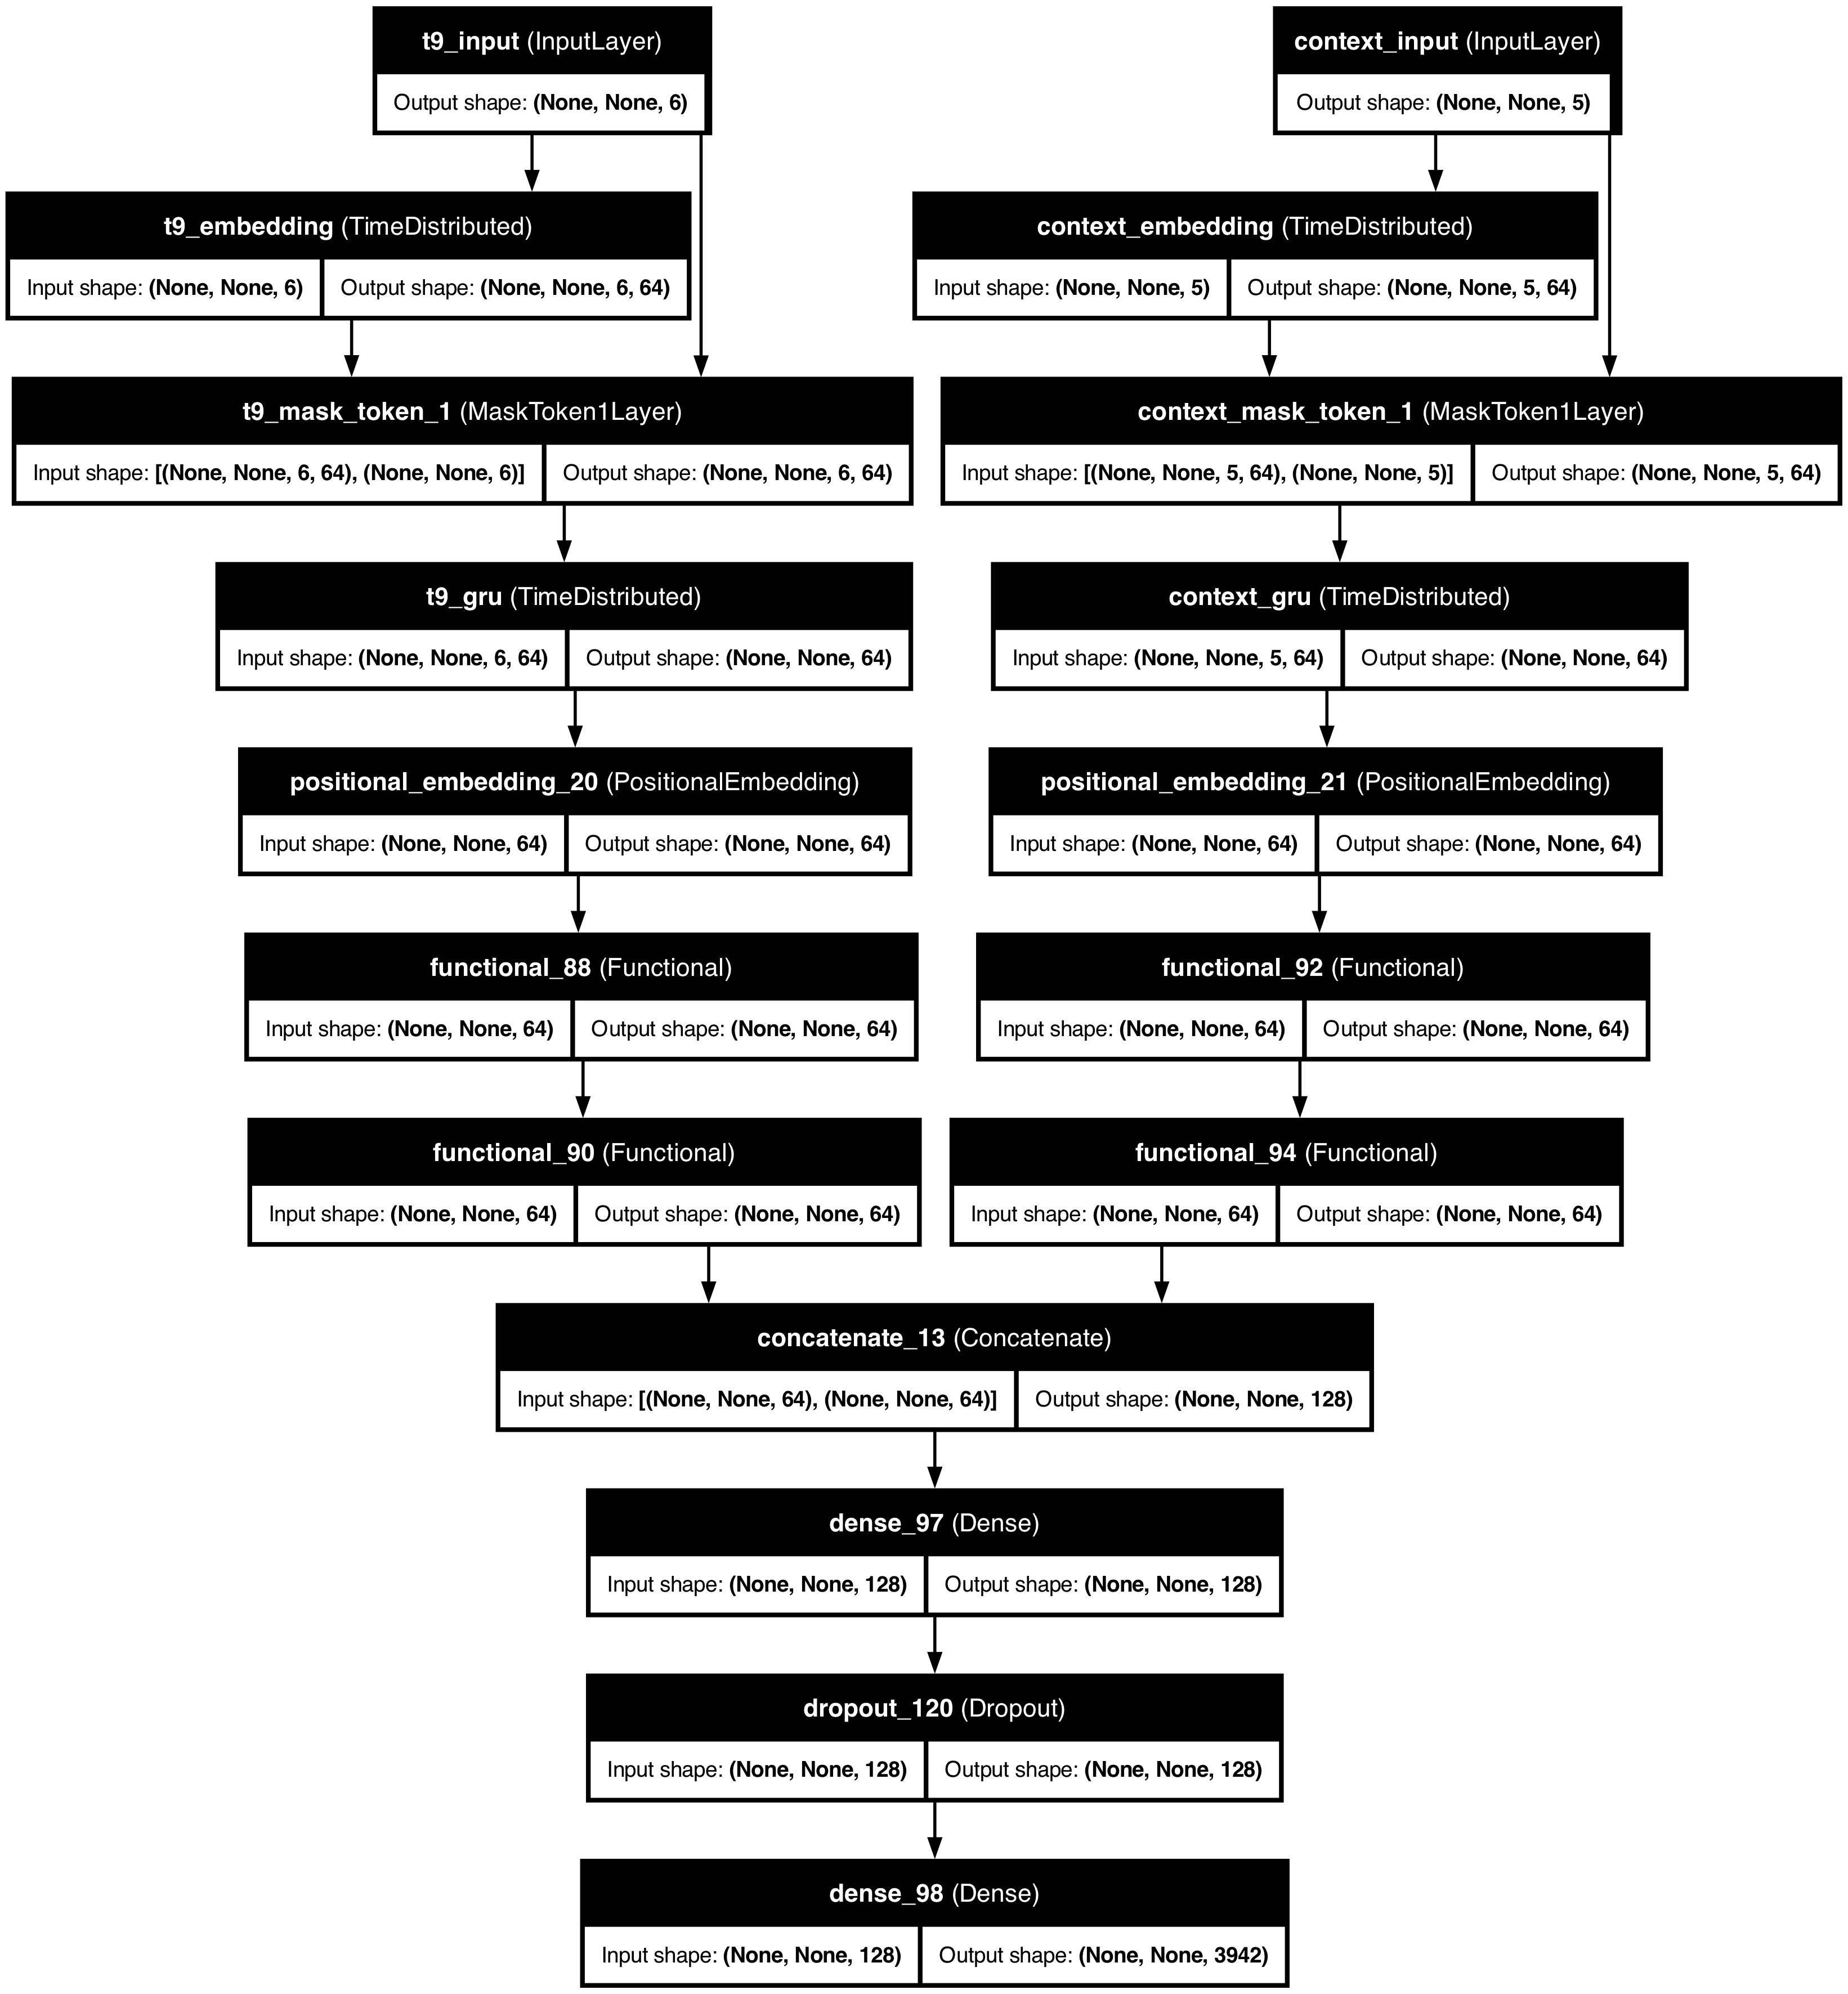

In [48]:
model_transformer = build_transformer_model(input_tv, target_tv)
keras.utils.plot_model(model_transformer, show_shapes=True, show_layer_names=True, to_file="model_transformer.png")

In [49]:
model_transformer.fit(ds_train_padded.take(20), 
                      epochs=30, 
                      validation_data=ds_val_padded.take(10), 
                      callbacks=[early_stopping]
                      )

model_transformer.save("models/model_transformer.keras")

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 325s 12s/step - loss: 7.0011 - perplexity: 2321.4106 - sparse_categorical_accuracy: 0.0038 - weighted_sparse_categorical_accuracy: 0.0041 - val_loss: 6.1170 - val_perplexity: 764.3062 - val_sparse_categorical_accuracy: 0.0189 - val_weighted_sparse_categorical_accuracy: 0.0205
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - loss: 6.0480 - perplexity: 759.6627 - sparse_categorical_accuracy: 0.0193 - weighted_sparse_categorical_accuracy: 0.0212 - val_loss: 6.0567 - val_perplexity: 715.9193 - val_sparse_categorical_accuracy: 0.0282 - val_weighted_sparse_categorical_accuracy: 0.0307
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 5.9343 - perplexity: 671.6906 - sparse_categorical_accuracy: 0.0344 - weighted_sparse_categorical_accuracy: 0.0378 - val_loss: 5.5394 - val_perplexity: 408.2949 - val_sparse_categorical_accuracy: 0.0484 - val_weighted_sparse_categorical_accuracy: 0.0526
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 5.3

# Évaluation

In [51]:
def evaluate_models(model_simple, model_with_1_mask, model_transformer, ds_test):
    print("Évaluation du modèle simple...")
    metrics_simple = model_simple.evaluate(ds_test, verbose=1, return_dict=True)
    # print("Metrics returned for model_simple:", metrics_simple)

    print("\nÉvaluation du modèle avec 1 masqué...")
    metrics_1_mask = model_with_1_mask.evaluate(ds_test, verbose=1, return_dict=True)
    # print("Metrics returned for model_with_1_mask:", metrics_1_mask)

    print("\nÉvaluation du modèle Transformer...")
    metrics_transformer = model_transformer.evaluate(ds_test, verbose=1, return_dict=True)
    # print("Metrics returned for model_transformer:", metrics_transformer)
    
    # Extract metrics
    loss_simple = metrics_simple['loss']
    perplexity_simple = metrics_simple.get('perplexity', 0.0)  # Use .get() to handle missing metrics
    acc_simple = metrics_simple.get('sparse_categorical_accuracy', 0.0)
    weighted_acc_simple = metrics_simple.get('weighted_sparse_categorical_accuracy', 0.0)

    loss_1_mask = metrics_1_mask['loss']
    perplexity_1_mask = metrics_1_mask.get('perplexity', 0.0)
    acc_1_mask = metrics_1_mask.get('sparse_categorical_accuracy', 0.0)
    weighted_acc_1_mask = metrics_1_mask.get('weighted_sparse_categorical_accuracy', 0.0)

    loss_transformer = metrics_transformer['loss']
    perplexity_transformer = metrics_transformer.get('perplexity', 0.0)
    acc_transformer = metrics_transformer.get('sparse_categorical_accuracy', 0.0)
    weighted_acc_transformer = metrics_transformer.get('weighted_sparse_categorical_accuracy', 0.0)

    print(f"\nRésultats :")
    print(f"Modèle simple - Perte : {loss_simple:.4f}, Précision : {acc_simple:.4f}")
    print(f"Modèle avec 1 masqué - Perte : {loss_1_mask:.4f}, Précision : {acc_1_mask:.4f}")
    print(f"Modèle Transformer - Perte : {loss_transformer:.4f}, Précision : {acc_transformer:.4f}")

    return {
        "simple": {"loss": loss_simple, "accuracy": acc_simple, "perplexity": perplexity_simple, "weighted_accuracy": weighted_acc_simple},
        "with_1_mask": {"loss": loss_1_mask, "accuracy": acc_1_mask, "perplexity": perplexity_1_mask, "weighted_accuracy": weighted_acc_1_mask},
        "transformer" : {"loss": loss_transformer, "accuracy": acc_transformer, "perplexity": perplexity_transformer, "weighted_accuracy": weighted_acc_transformer}
    }

# Charger les deux modèles depuis les fichiers
model_simple = keras.models.load_model("models/model_simple.keras")
model_with_1_mask = keras.models.load_model("models/model_with_1_mask.keras", custom_objects={"MaskToken1Layer": MaskToken1Layer})
model_transformer = keras.models.load_model("models/model_transformer.keras", custom_objects={"PositionalEmbedding": PositionalEmbedding, "transformer_block": transformer_block, "MaskToken1Layer": MaskToken1Layer})

# Évaluer
results = evaluate_models(model_simple, model_with_1_mask, model_transformer, ds_test_padded)

/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'positional_embedding_20', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/perrineqhn/Desktop/M2/S2/Méthode en Apprentissage Automatique/tf_metal_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'positional_embedding_21', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  war

Évaluation du modèle simple...
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - loss: 1.6908 - perplexity: 6.3178 - sparse_categorical_accuracy: 0.5592 - weighted_sparse_categorical_accuracy: 0.6095

Évaluation du modèle avec 1 masqué...
16/16 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - loss: 0.9290 - perplexity: 2.7536 - sparse_categorical_accuracy: 0.6697 - weighted_sparse_categorical_accuracy: 0.7300

Évaluation du modèle Transformer...
16/16 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - loss: 0.0964 - perplexity: 1.1108 - sparse_categorical_accuracy: 0.9082 - weighted_sparse_categorical_accuracy: 0.9899

Résultats :
Modèle simple - Perte : 1.6916, Précision : 0.5606
Modèle avec 1 masqué - Perte : 0.9331, Précision : 0.6692
Modèle Transformer - Perte : 0.0978, Précision : 0.9094


# Génération

In [41]:
def generate_text(model, input_t9_sequence, context_chars, input_tv, target_tv, max_length=100, context_size=5):
    """
    Génère une séquence de caractères chinois à partir d'une séquence T9 et d'un contexte en sinogrammes.
    
    Args:
        model: Modèle Keras entraîné.
        input_t9_sequence: Chaîne de séquences T9 séparées par des espaces (ex. "94664 486").
        context_chars: Liste de caractères chinois pour le contexte initial (ex. ["经", "央"]).
        input_tv: Couche TextVectorization pour les entrées T9.
        target_tv: Couche TextVectorization pour les caractères cibles.
        max_length: Longueur maximale de la séquence générée.
        context_size: Taille du contexte (nombre de caractères précédents utilisés).
    
    Returns:
        Chaîne de caractères chinois générée.
    """
    # Préparer l'entrée T9
    t9_tokens = input_t9_sequence.strip().split(" ")
    t9_tokens = t9_tokens[:max_length]  # Limiter à max_length
    if not t9_tokens:
        return ""
    
    # Vectoriser les tokens T9
    t9_vectorized = input_tv(t9_tokens).to_tensor(default_value=0, shape=(len(t9_tokens), 6))
    t9_vectorized = tf.expand_dims(t9_vectorized, axis=0)  # Shape: (1, seq_len, 6)
    
    # Initialiser le contexte avec les caractères fournis
    context = []
    if context_chars:
        # Vectoriser les caractères de contexte
        context_ids = target_tv(context_chars).to_tensor(default_value=0).numpy().flatten().tolist()
        context.extend(context_ids)
    # Remplir avec des zéros si le contexte est trop court
    while len(context) < context_size:
        context.insert(0, 0)  # Padding avec 0 (sera masqué)
    # Tronquer si le contexte est trop long
    context = context[-context_size:]
    
    # Initialiser la séquence générée
    generated_chars = []
    
    # Générer caractère par caractère
    for i in range(len(t9_tokens)):
        # Préparer le contexte
        context_tensor = tf.constant([context[-context_size:]], dtype=tf.int64)
        context_tensor = tf.expand_dims(context_tensor, axis=1)  # Shape: (1, 1, context_size)
        context_tensor = tf.repeat(context_tensor, repeats=tf.shape(t9_vectorized)[1], axis=1)
        
        # Prédire le caractère suivant
        inputs = {
            "t9_input": t9_vectorized,
            "context_input": context_tensor
        }
        predictions = model.predict(inputs, verbose=0)  # Shape: (1, seq_len, vocab_size)
        
        # Obtenir la prédiction pour la position actuelle
        pred_char_idx = np.argmax(predictions[0, i], axis=-1)
        pred_char = target_tv.get_vocabulary()[pred_char_idx]
        
        # Ajouter le caractère généré (sauf si c'est un token spécial)
        if pred_char not in ['', '[UNK]']:
            generated_chars.append(pred_char)
        
        # Mettre à jour le contexte
        context.append(int(pred_char_idx))
        if len(context) > context_size:
            context.pop(0)
    
    # Convertir la liste de caractères en chaîne
    return ''.join(generated_chars)

In [42]:
test_cases = [
    {
        "t9_input": "94664 486",  # 中国
        "context_chars": ["经", "央"],  # Contexte: caractères précédents
        "description": "Générer '中国' avec contexte '经央'",
        "expected": "中国"
    },
    {
        "t9_input": "5464 94664 9264",  # 经中央
        "context_chars": ["广", "大"],  # Contexte: caractères précédents
        "description": "Générer '经中央' avec contexte '广大'",
        "expected": "经中央"
    },
    {
        "t9_input": "48264 32 3264",  # 广大党
        "context_chars": ["中", "国"],  # Contexte: caractères précédents
        "description": "Générer '广大党' avec contexte '中国'",
        "expected": "广大党"
    },
    {
        "t9_input": "1 94664 486",  # masked token + 中国
        "context_chars": ["党"],  # Contexte minimum
        "description": "Tester le masquage de l'ID de token 1 avec '中国' et le contexte '党'",
        "expected": "中国"  # Token ID 1 should be ignored
    },
    {
        "t9_input": "0 94664 486",  # Padding + 中国
        "context_chars": ["经", "央", "广"],  # Contexte long
        "description": "Tester le masquage de l'ID de token 0 avec '中国' et le contexte '经央广'",
        "expected": "中国"  # Token ID 0 should be ignored
    },
    {
        "t9_input": "94664 486 5464 94664 9264",  # 中国经中央
        "context_chars": [],  # Aucun contexte
        "description": "Générer '中国经中央' sans contexte",
        "expected": "中国经中央"
    }
]

for test_case in test_cases:
    generated_text = generate_text(
        model_simple,
        test_case["t9_input"],
        test_case["context_chars"],
        input_tv,
        target_tv
    )
    print(f"Test case: {test_case['description']}")
    print(f"Expected: {test_case['expected']}")
    print(f"Generated: {generated_text}")
    print("-" * 50)

Test case: Générer '中国' avec contexte '经央'
Expected: 中国
Generated: 中国
--------------------------------------------------
Test case: Générer '经中央' avec contexte '广大'
Expected: 经中央
Generated: 精中央
--------------------------------------------------
Test case: Générer '广大党' avec contexte '中国'
Expected: 广大党
Generated: 广大当
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 1 avec '中国' et le contexte '党'
Expected: 中国
Generated: 的中国
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 0 avec '中国' et le contexte '经央广'
Expected: 中国
Generated: 举行国
--------------------------------------------------
Test case: Générer '中国经中央' sans contexte
Expected: 中国经中央
Generated: 中国经中央
--------------------------------------------------


In [43]:
for test_case in test_cases:
    generated_text = generate_text(
        model_with_1_mask,
        test_case["t9_input"],
        test_case["context_chars"],
        input_tv,
        target_tv
    )
    print(f"Test case: {test_case['description']}")
    print(f"Expected: {test_case['expected']}")
    print(f"Generated: {generated_text}")
    print("-" * 50)

Test case: Générer '中国' avec contexte '经央'
Expected: 中国
Generated: 中国
--------------------------------------------------
Test case: Générer '经中央' avec contexte '广大'
Expected: 经中央
Generated: 精中央
--------------------------------------------------
Test case: Générer '广大党' avec contexte '中国'
Expected: 广大党
Generated: 广大党
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 1 avec '中国' et le contexte '党'
Expected: 中国
Generated: 科中国
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 0 avec '中国' et le contexte '经央广'
Expected: 中国
Generated: 剧中国
--------------------------------------------------
Test case: Générer '中国经中央' sans contexte
Expected: 中国经中央
Generated: 中国经中央
--------------------------------------------------


In [44]:
for test_case in test_cases:
    generated_text = generate_text(
        model_transformer,
        test_case["t9_input"],
        test_case["context_chars"],
        input_tv,
        target_tv
    )
    print(f"Test case: {test_case['description']}")
    print(f"Expected: {test_case['expected']}")
    print(f"Generated: {generated_text}")
    print("-" * 50)

Test case: Générer '中国' avec contexte '经央'
Expected: 中国
Generated: 中国
--------------------------------------------------
Test case: Générer '经中央' avec contexte '广大'
Expected: 经中央
Generated: 经中展
--------------------------------------------------
Test case: Générer '广大党' avec contexte '中国'
Expected: 广大党
Generated: 广大电
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 1 avec '中国' et le contexte '党'
Expected: 中国
Generated: 俄中国
--------------------------------------------------
Test case: Tester le masquage de l'ID de token 0 avec '中国' et le contexte '经央广'
Expected: 中国
Generated: 俄中国
--------------------------------------------------
Test case: Générer '中国经中央' sans contexte
Expected: 中国经中央
Generated: 中国经中展
--------------------------------------------------
